# Kütüphanelerin ve Veri Setinin yüklenmesi

In [3]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import os
from sklearn.model_selection import train_test_split
from PIL import Image
from sklearn.metrics import confusion_matrix, classification_report



In [4]:
label = []
path = []
fish_dir = '/kaggle/input/a-large-scale-fish-dataset'
for dir_name, _, filenames in os.walk(fish_dir):
    for filename in filenames:
        if os.path.splitext(filename)[-1] == '.png':
            if dir_name.split()[-1]!= 'GT':
                label.append(os.path.split(dir_name)[-1])
                path.append(os.path.join(dir_name, filename))

data = pd.DataFrame(columns = ['path','label'])
data['path'] = path
data['label'] = label

# Veri Setini ayıklama ve Görselleştirme

In [5]:
# İlgili sınıfları ayırma
selected_classes = ["Sea Bass", "Gilt-Head Bream", "Red Sea Bream"]
filtered_df = data[data['label'].isin(selected_classes)]

# Ayrılmış veriyi kontrol edelim
print(filtered_df['label'].value_counts())


label
Sea Bass           1000
Gilt-Head Bream    1000
Red Sea Bream      1000
Name: count, dtype: int64


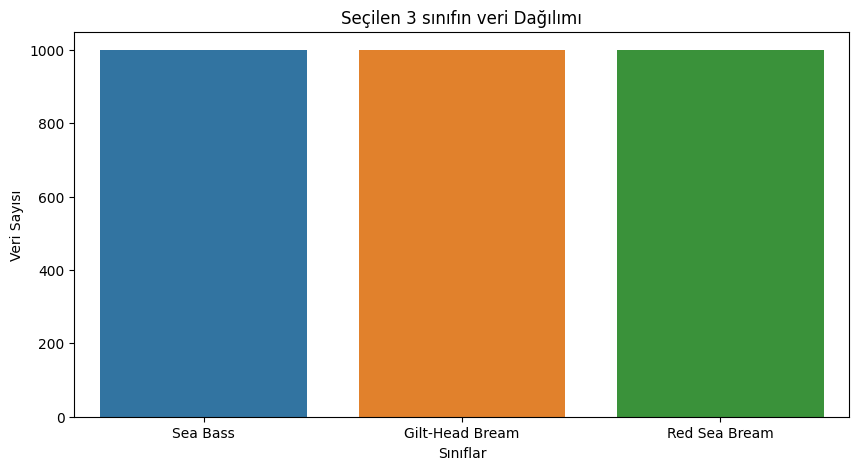

In [6]:
# Sınıf dağılımı
plt.figure(figsize=(10, 5))
sns.countplot(data=filtered_df, x='label')
plt.title('Seçilen 3 sınıfın veri Dağılımı')
plt.xlabel('Sınıflar')
plt.ylabel('Veri Sayısı')
plt.show()


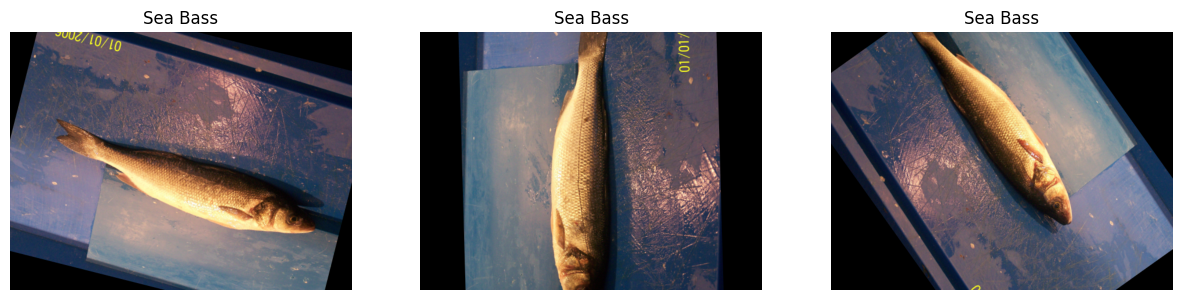

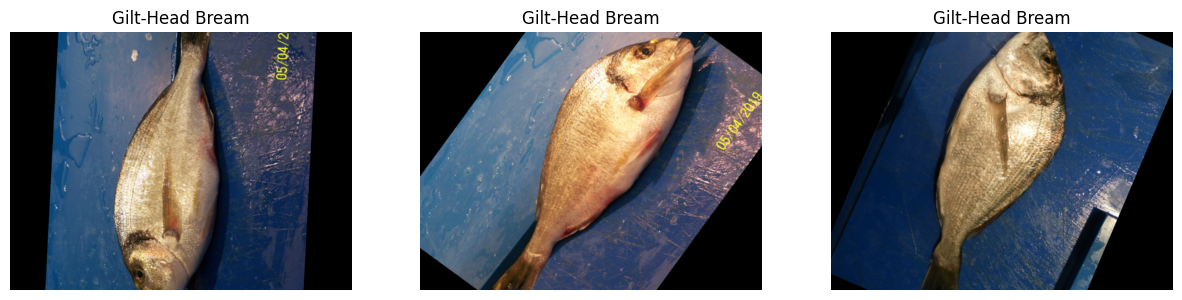

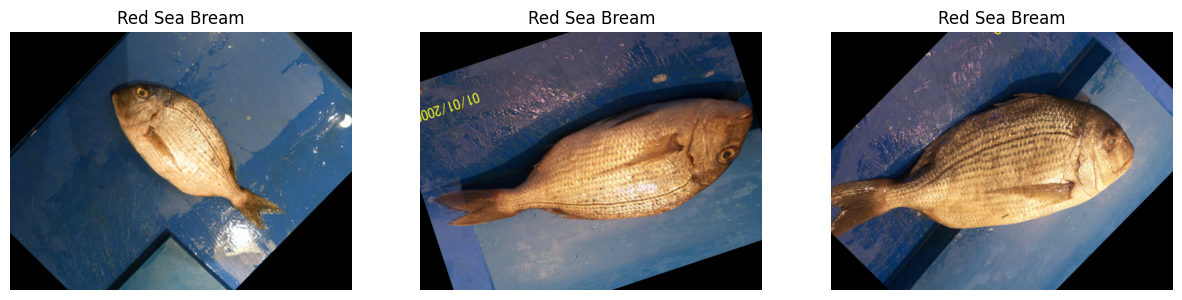

In [7]:

def show_images(df, class_name, num_samples=3):
    # Verilen sınıfa ait belirli sayıda örnek göster
    sample_df = df[df['label'] == class_name].sample(num_samples)
    plt.figure(figsize=(15, 5))

    for i, (index, row) in enumerate(sample_df.iterrows()):
        img = Image.open(row['path'])
        plt.subplot(1, num_samples, i + 1)
        plt.imshow(img)
        plt.title(class_name)
        plt.axis('off')

    plt.show()

# Seçilen 3 sınıfın her birinden 3 fotoğraf göster
for class_name in selected_classes:
    show_images(filtered_df, class_name, num_samples=3)


# Veri Seti Ayırma 

In [8]:

# Veriyi ayırma işlemi
train_df, test_df = train_test_split(filtered_df, test_size=0.2, stratify=filtered_df['label'], random_state=42)

# Eğitim ve test setlerini kontrol edelim
print("Eğitim Seti Boyutu:", train_df.shape)
print("Test Seti Boyutu:", test_df.shape)


Eğitim Seti Boyutu: (2400, 2)
Test Seti Boyutu: (600, 2)


# Model Seçimi

Pytorch Seçmemin sebebi bu zamana kadar genellikle bu kütüphane ile çalışmam ve TensorFlow'a göre daha akıcı, hızlı ve performanslı olduğunu düşünmem. 

In [9]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from PIL import Image


Buradaki katman konusunda GPT'den ve kendi sitesindeki Tutorial'dan yardım aldım. 

In [10]:
# Veriyi yüklemek ve dönüştürmek için transformasyonlar tanımlama
transform = transforms.Compose([
    transforms.Resize((128, 128)),  # Fotoğrafların boyutlarını düzenleme
    transforms.ToTensor(),  # Fotoğrafları tensöre dönüştürme
])

# Özelleştirilmiş Dataset sınıfı tanımlama
class FishDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.dataframe = dataframe
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        img_path = self.dataframe.iloc[idx]['path']
        label = self.dataframe.iloc[idx]['label']
        image = Image.open(img_path).convert('RGB')
        
        if self.transform:
            image = self.transform(image)

        # Label'ı sayısal değere dönüştürme
        label_map = {"Sea Bass": 0, "Gilt-Head Bream": 1, "Red Sea Bream": 2}
        label = label_map[label]
        
        return image, label

# Dataset ve DataLoader tanımlama
train_dataset = FishDataset(train_df, transform=transform)
test_dataset = FishDataset(test_df, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


In [11]:
# Basit bir Yapay Sinir Ağı (ANN) modeli tanımlama
model = nn.Sequential(
    nn.Flatten(),  
    nn.Linear(128 * 128 * 3, 512),
    nn.ReLU(),
    nn.Dropout(0.3),
    nn.Linear(512, 128),
    nn.ReLU(),
    nn.Linear(128, 3)  

# Cihaz tanımlama (GPU varsa kullan)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)


Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=49152, out_features=512, bias=True)
  (2): ReLU()
  (3): Dropout(p=0.3, inplace=False)
  (4): Linear(in_features=512, out_features=128, bias=True)
  (5): ReLU()
  (6): Linear(in_features=128, out_features=3, bias=True)
)

# Model Eğitimi

In [23]:
def train_model_with_validation(model, train_loader, test_loader, criterion, optimizer, num_epochs=10):
    model.train()
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []

    for epoch in range(num_epochs):
        # Eğitim aşaması
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            
            # İleri besleme
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        
        train_loss = running_loss / len(train_loader.dataset)
        train_accuracy = 100 * correct / total
        train_losses.append(train_loss)
        train_accuracies.append(train_accuracy)
        
        # Doğrulama aşaması
        model.eval()
        val_loss = 0.0
        correct = 0
        total = 0

        with torch.no_grad():
            for images, labels in test_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                
                val_loss += loss.item() * images.size(0)
                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        val_loss /= len(test_loader.dataset)
        val_accuracy = 100 * correct / total
        val_losses.append(val_loss)
        val_accuracies.append(val_accuracy)

        print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}, Train Acc: {train_accuracy:.2f}%, Validation Acc: {val_accuracy:.2f}%")

    return train_losses, val_losses, train_accuracies, val_accuracies

# Modeli eğitme ve kayıpları izleme
train_losses, val_losses, train_accuracies, val_accuracies = train_model_with_validation(
    model_optimized, train_loader_optimized, test_loader_optimized, criterion_optimized, optimizer_optimized, num_epochs=10
)


Epoch 1/10, Train Loss: 0.2033, Validation Loss: 0.0872, Train Acc: 91.58%, Validation Acc: 97.67%
Epoch 2/10, Train Loss: 0.2607, Validation Loss: 0.0983, Train Acc: 89.92%, Validation Acc: 96.00%
Epoch 3/10, Train Loss: 0.2487, Validation Loss: 0.1295, Train Acc: 89.21%, Validation Acc: 95.17%
Epoch 4/10, Train Loss: 0.2623, Validation Loss: 0.0902, Train Acc: 88.46%, Validation Acc: 97.17%
Epoch 5/10, Train Loss: 0.1790, Validation Loss: 0.0788, Train Acc: 93.00%, Validation Acc: 97.00%
Epoch 6/10, Train Loss: 0.1683, Validation Loss: 0.1008, Train Acc: 93.46%, Validation Acc: 95.67%
Epoch 7/10, Train Loss: 0.2006, Validation Loss: 0.0868, Train Acc: 92.29%, Validation Acc: 97.33%
Epoch 8/10, Train Loss: 0.2064, Validation Loss: 0.0416, Train Acc: 92.04%, Validation Acc: 98.67%
Epoch 9/10, Train Loss: 0.2207, Validation Loss: 0.0732, Train Acc: 90.46%, Validation Acc: 97.00%
Epoch 10/10, Train Loss: 0.2305, Validation Loss: 0.1133, Train Acc: 90.50%, Validation Acc: 95.33%


# Model Değerlendirme ve Matrixler

In [24]:
def evaluate_model(model, test_loader):
    model.eval()  # Modeli değerlendirme moduna geçirme
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    print(f"Test Accuracy: {100 * correct / total:.2f}%")

# Modeli değerlendirme
evaluate_model(model, test_loader)


Test Accuracy: 92.33%


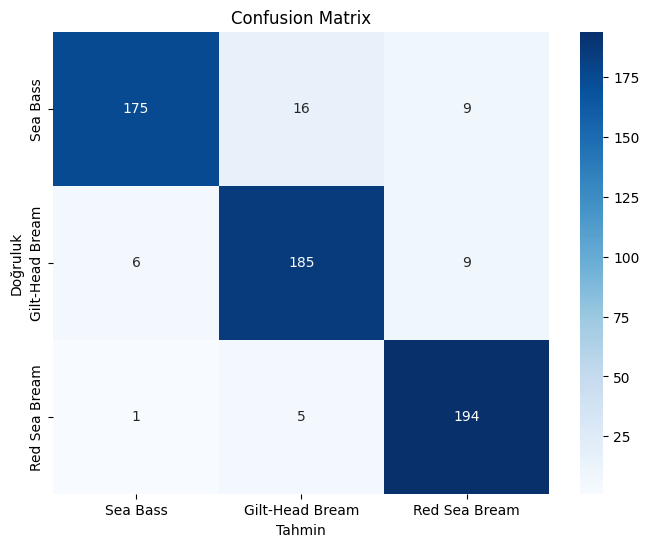

Classification Report:
                 precision    recall  f1-score   support

       Sea Bass       0.96      0.88      0.92       200
Gilt-Head Bream       0.90      0.93      0.91       200
  Red Sea Bream       0.92      0.97      0.94       200

       accuracy                           0.92       600
      macro avg       0.92      0.92      0.92       600
   weighted avg       0.92      0.92      0.92       600



In [25]:


# Confusion Matrix ve Classification Report fonksiyonu
def evaluate_with_metrics(model, test_loader):
    model.eval()  # Modeli değerlendirme moduna geçirme
    y_true = []
    y_pred = []

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(predicted.cpu().numpy())

    # Confusion matrix oluşturma
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["Sea Bass", "Gilt-Head Bream", "Red Sea Bream"], yticklabels=["Sea Bass", "Gilt-Head Bream", "Red Sea Bream"])
    plt.xlabel("Tahmin")
    plt.ylabel("Doğruluk")
    plt.title("Confusion Matrix")
    plt.show()

    # Classification report yazdırma
    print("Classification Report:")
    print(classification_report(y_true, y_pred, target_names=["Sea Bass", "Gilt-Head Bream", "Red Sea Bream"]))

# Modeli confusion matrix ve classification report ile değerlendirme
evaluate_with_metrics(model, test_loader)


# Optimize edilmiş farklı bir model eğitimi

In [26]:
# Yeni model tanımı (katman sayısı artırıldı ve dropout oranı eklendi)
model_optimized = nn.Sequential(
    nn.Flatten(),
    nn.Linear(128 * 128 * 3, 1024),  # Daha fazla düğüm
    nn.ReLU(),
    nn.Dropout(0.4),  # Dropout oranını artırdık
    nn.Linear(1024, 512),
    nn.ReLU(),
    nn.Dropout(0.4),
    nn.Linear(512, 128),
    nn.ReLU(),
    nn.Linear(128, 3)  # Çıkış katmanı, 3 sınıf için
)

# Cihaz tanımlama (GPU varsa kullan)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_optimized.to(device)


Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=49152, out_features=1024, bias=True)
  (2): ReLU()
  (3): Dropout(p=0.4, inplace=False)
  (4): Linear(in_features=1024, out_features=512, bias=True)
  (5): ReLU()
  (6): Dropout(p=0.4, inplace=False)
  (7): Linear(in_features=512, out_features=128, bias=True)
  (8): ReLU()
  (9): Linear(in_features=128, out_features=3, bias=True)
)

In [27]:
# Yeni batch size ile DataLoader tanımlama
train_loader_optimized = DataLoader(train_dataset, batch_size=64, shuffle=True)  # Batch size artırıldı
test_loader_optimized = DataLoader(test_dataset, batch_size=64, shuffle=False)

# Yeni optimizer ve loss fonksiyonu tanımlama
optimizer_optimized = optim.Adam(model_optimized.parameters(), lr=0.0005)  # Daha düşük öğrenme oranı
criterion_optimized = nn.CrossEntropyLoss()

# Yeni eğitim fonksiyonu
def train_model_optimized(model, train_loader, criterion, optimizer, num_epochs=10):
    model.train()  # Modeli eğitim moduna geçirme
    for epoch in range(num_epochs):
        running_loss = 0.0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            
            # Sıfırlama
            optimizer.zero_grad()
            
            # İleri besleme
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            # Geri yayılım ve optimizasyon
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item() * images.size(0)
        
        epoch_loss = running_loss / len(train_loader.dataset)
        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}")

# Yeni modeli eğitme
train_model_optimized(model_optimized, train_loader_optimized, criterion_optimized, optimizer_optimized, num_epochs=10)


Epoch 1/10, Loss: 1.2309
Epoch 2/10, Loss: 0.9633
Epoch 3/10, Loss: 0.7013
Epoch 4/10, Loss: 0.4400
Epoch 5/10, Loss: 0.3755
Epoch 6/10, Loss: 0.3317
Epoch 7/10, Loss: 0.3167
Epoch 8/10, Loss: 0.2033
Epoch 9/10, Loss: 0.2121
Epoch 10/10, Loss: 0.1644


# Optimize modelin, model değerlendirilmesi

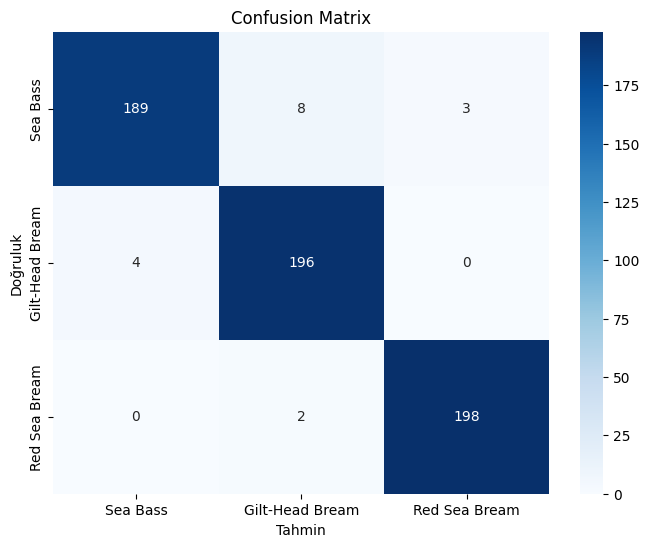

Classification Report:
                 precision    recall  f1-score   support

       Sea Bass       0.98      0.94      0.96       200
Gilt-Head Bream       0.95      0.98      0.97       200
  Red Sea Bream       0.99      0.99      0.99       200

       accuracy                           0.97       600
      macro avg       0.97      0.97      0.97       600
   weighted avg       0.97      0.97      0.97       600



In [28]:
# Yeni model için değerlendirme fonksiyonu
evaluate_with_metrics(model_optimized, test_loader_optimized)


In [22]:
def train_model_with_validation(model, train_loader, test_loader, criterion, optimizer, num_epochs=30):
    model.train()
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []

    for epoch in range(num_epochs):
        # Eğitim aşaması
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            
            # İleri besleme
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        
        train_loss = running_loss / len(train_loader.dataset)
        train_accuracy = 100 * correct / total
        train_losses.append(train_loss)
        train_accuracies.append(train_accuracy)
        
        # Doğrulama aşaması
        model.eval()
        val_loss = 0.0
        correct = 0
        total = 0

        with torch.no_grad():
            for images, labels in test_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                
                val_loss += loss.item() * images.size(0)
                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        val_loss /= len(test_loader.dataset)
        val_accuracy = 100 * correct / total
        val_losses.append(val_loss)
        val_accuracies.append(val_accuracy)

        print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}, Train Acc: {train_accuracy:.2f}%, Validation Acc: {val_accuracy:.2f}%")

    return train_losses, val_losses, train_accuracies, val_accuracies

# Modeli eğitme ve kayıpları izleme
train_losses, val_losses, train_accuracies, val_accuracies = train_model_with_validation(
    model_optimized, train_loader_optimized, test_loader_optimized, criterion_optimized, optimizer_optimized, num_epochs=10
)


Epoch 1/10, Train Loss: 0.1597, Validation Loss: 0.0727, Train Acc: 93.75%, Validation Acc: 97.83%
Epoch 2/10, Train Loss: 0.1757, Validation Loss: 0.0803, Train Acc: 92.58%, Validation Acc: 96.33%
Epoch 3/10, Train Loss: 0.1614, Validation Loss: 0.0784, Train Acc: 92.79%, Validation Acc: 96.83%
Epoch 4/10, Train Loss: 0.1666, Validation Loss: 0.0999, Train Acc: 93.25%, Validation Acc: 96.17%
Epoch 5/10, Train Loss: 0.1621, Validation Loss: 0.1423, Train Acc: 93.04%, Validation Acc: 95.33%
Epoch 6/10, Train Loss: 0.2305, Validation Loss: 0.1056, Train Acc: 90.08%, Validation Acc: 96.33%
Epoch 7/10, Train Loss: 0.2080, Validation Loss: 0.0835, Train Acc: 90.92%, Validation Acc: 97.00%
Epoch 8/10, Train Loss: 0.1827, Validation Loss: 0.1015, Train Acc: 91.00%, Validation Acc: 97.17%
Epoch 9/10, Train Loss: 0.2086, Validation Loss: 0.0747, Train Acc: 90.83%, Validation Acc: 97.67%
Epoch 10/10, Train Loss: 0.1696, Validation Loss: 0.0862, Train Acc: 92.96%, Validation Acc: 97.33%


# Eğitim ve Validation Loss ve Accuracy Epoch Başına Karşılaştırılması

Overfiting olup olmadığını kontrol etmek için 

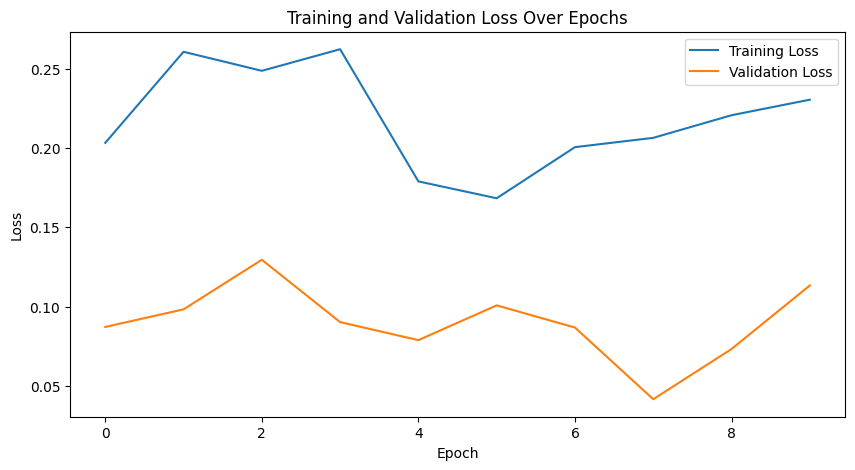

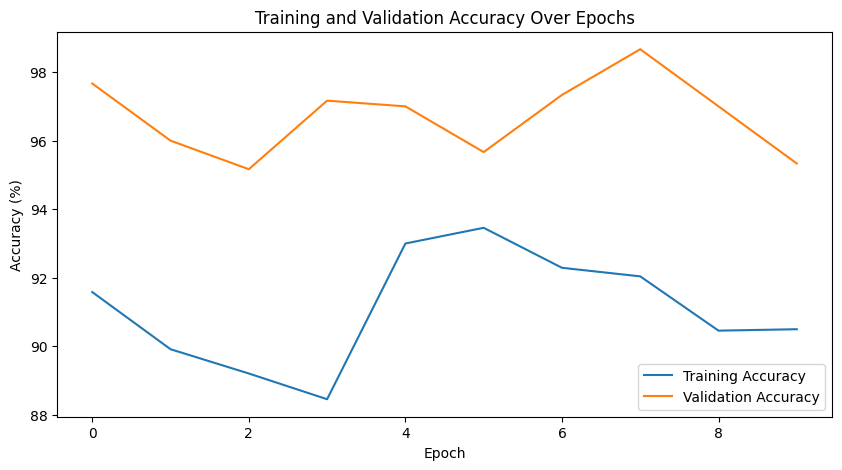

In [29]:

# Kayıp grafiği çizme
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Doğruluk grafiği çizme
plt.figure(figsize=(10, 5))
plt.plot(train_accuracies, label='Training Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.title('Training and Validation Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.show()
